In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap
import sys, os
sys.path.append(os.path.abspath("/autofs/nfshomes/ecovi/cml/mergeplg/src"))

from mergeplg import merge

In [3]:
# Load processed data, resolution 5 minutes
ds_gauges = xr.open_dataset("./data/AWS_202209170700_202209171030.nc")
ds_cmls = xr.open_dataset("./data/CML_202209170700_202209171030.nc")
ds_rad = xr.open_dataset("./data/RAD_202209170700_202209171030.nc")

#fix CML files
ds_cmls = ds_cmls.reduce(np.nanmean, dim='sublink_id')

# fix RG files
ds_gauges = ds_gauges.rename({"longitude": "lon", "latitude": "lat"})

# fix radar files
ds_rad = ds_rad.rename({"lon": "x", "lat": "y"})
ds_rad['lat'] = (('y','x'), np.array([ds_rad.y.values,]*len(ds_rad.x.values)).transpose())
ds_rad['lon'] = (('y','x'), np.array([ds_rad.x.values,]*len(ds_rad.y.values)))
ds_rad = ds_rad.set_coords(["lon", "lat"])

In [4]:
# Threshold lower values
radar_zero = 0.01  # here in sum mm over 15 minutes
ds_rad["rainfall_amount"] = xr.where(
    ds_rad.rainfall_amount > radar_zero, ds_rad.rainfall_amount, 0
)

# Project data

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

In [6]:
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

In [7]:
# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

In [8]:
# Projected radar coords
ds_rad.coords["xs"], ds_rad.coords["ys"] = plg.spatial.project_point_coordinates(
    ds_rad.lon, ds_rad.lat, ref_str
)

# Adjust rainfall fields

In [9]:
# Init and setup
additiveIDW = merge.MergeAdditiveIDW(ds_rad.rainfall_amount, ds_cmls.R)
additiveBlockKriging = merge.MergeAdditiveBlockKriging(
    ds_rad.rainfall_amount, ds_cmls.R
)
KEDBlockKriging = merge.MergeBlockKrigingExternalDrift(
    ds_rad.rainfall_amount, ds_cmls.R
)

In [10]:
# Do adjustment using additive IDW
adjusted_rainfall = []
for time in ds_cmls.time:
    adjusted_rainfall.append(additiveIDW(time))
ds_rad["rainfall_additiveIDW"] = xr.concat(adjusted_rainfall, dim="time")

In [11]:
# Do adjustment using additive BlockKriging
adjusted_rainfall = []
for time in ds_cmls.time:
    adjusted_rainfall.append(additiveBlockKriging(time))
ds_rad["rainfall_additiveBK"] = xr.concat(adjusted_rainfall, dim="time")

In [12]:
# Do adjustment using KED
adjusted_rainfall = []
for time in ds_cmls.time:
    adjusted_rainfall.append(KEDBlockKriging(time))
ds_rad["rainfall_KED"] = xr.concat(adjusted_rainfall, dim="time")

In [13]:
cmap_colors = [
    (0, "white"),
    (radar_zero, "white"),
    (radar_zero, (0.5, 0.75, 0.25, 1.0)),
    (1, "blue"),
]  # white -> green-yellow mix -> dark blue
cmap_rain = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

/tmp/ecovi/ipykernel_4125506/2492303819.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[0].pcolormesh(
/tmp/ecovi/ipykernel_4125506/2492303819.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(
/tmp/ecovi/ipykernel_4125506/2492303819.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[2].pcolormesh(
/tmp/ecovi/ipykernel_4125506/2492303819.py:33: Use

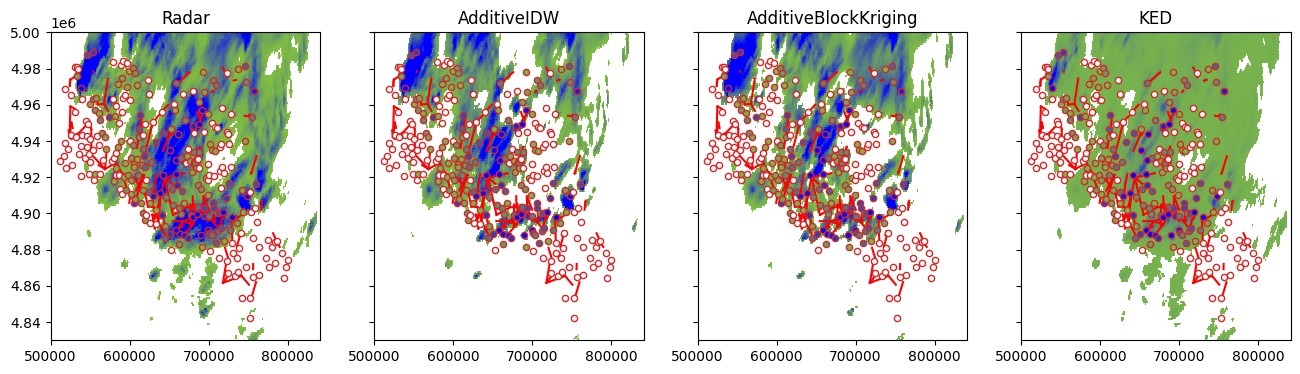

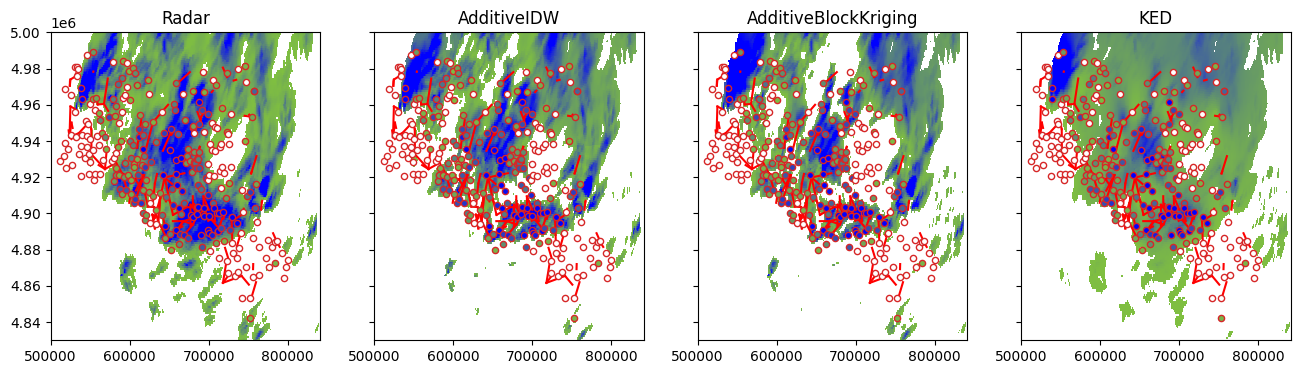

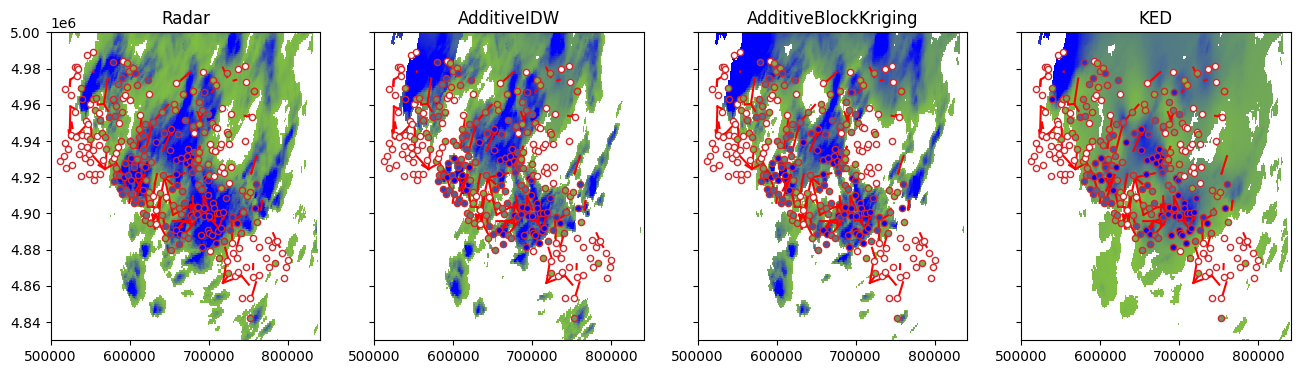

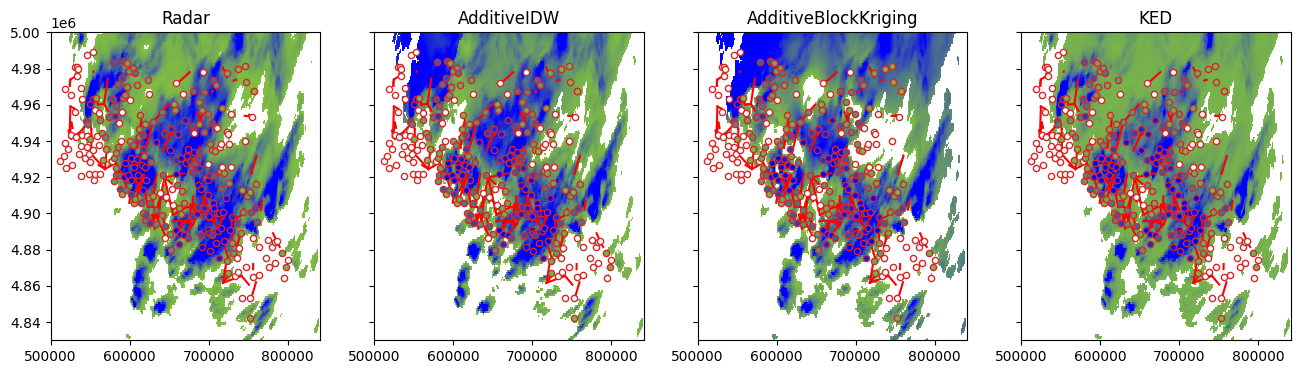

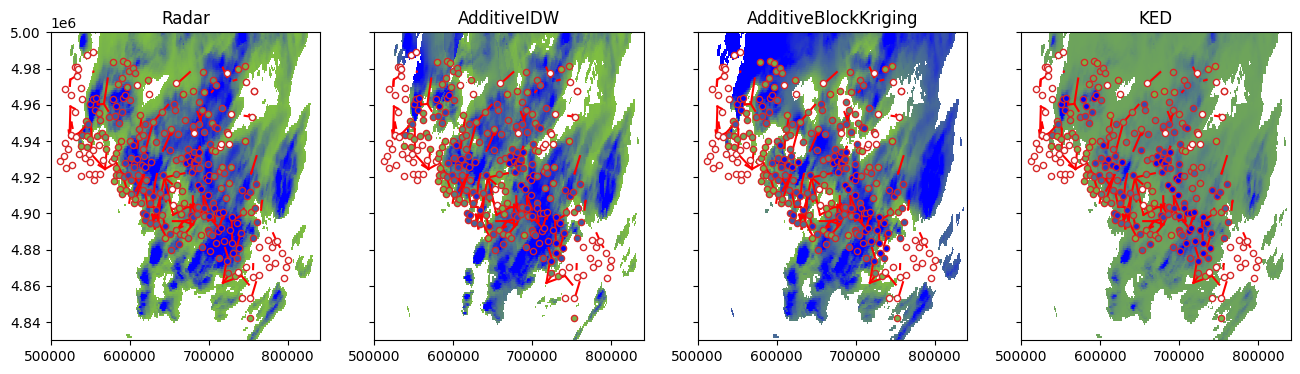

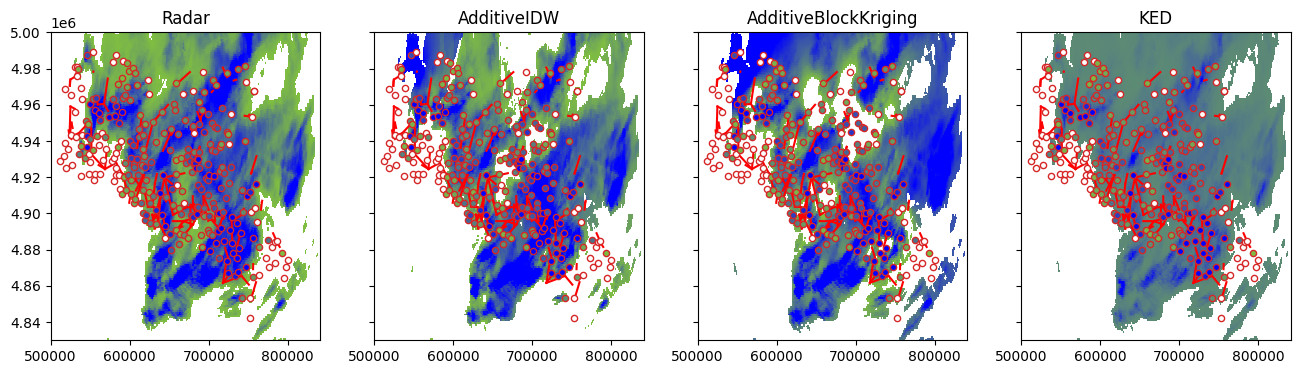

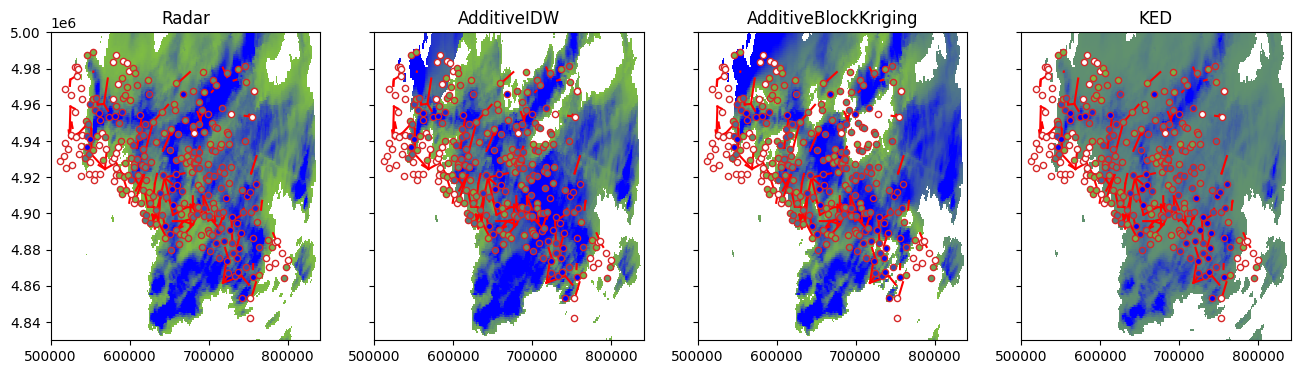

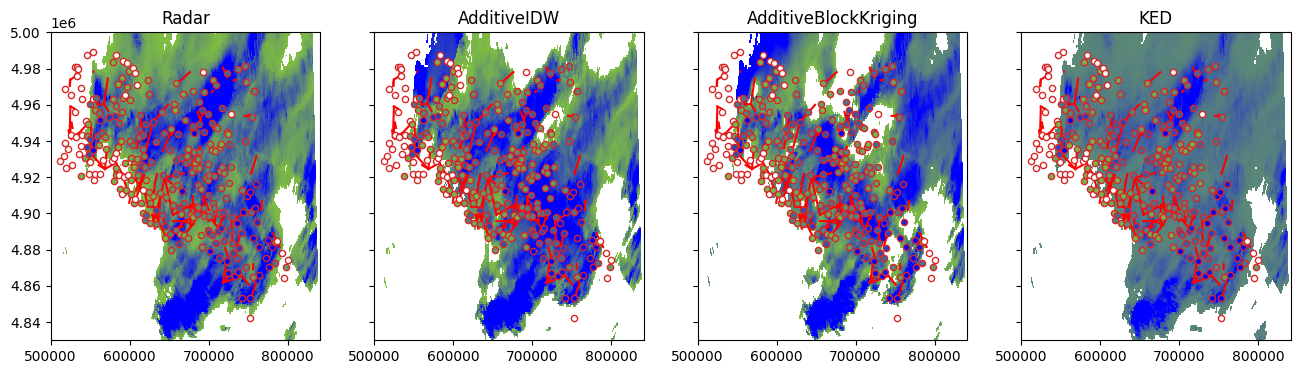

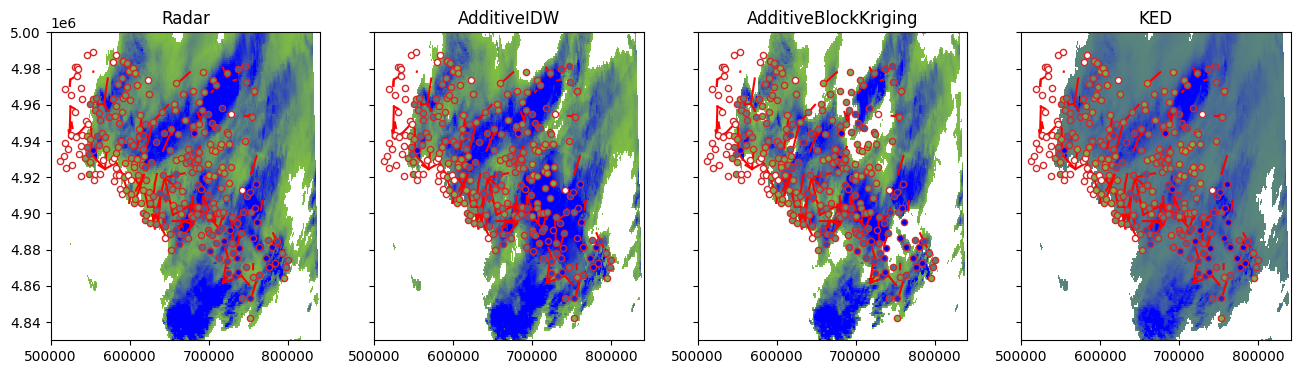

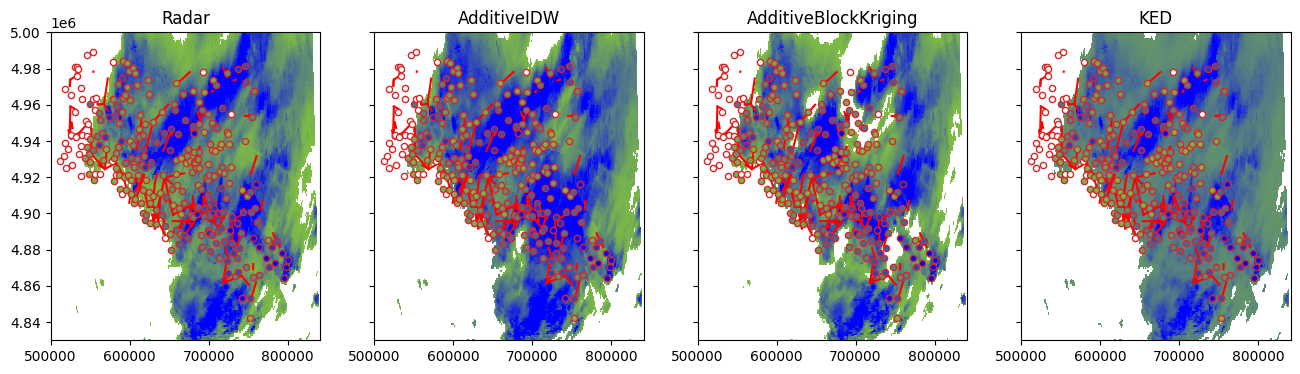

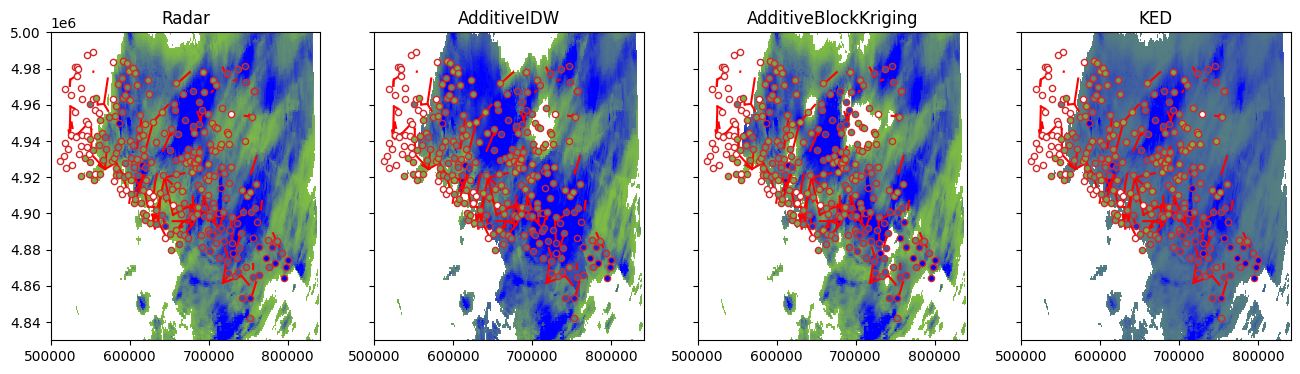

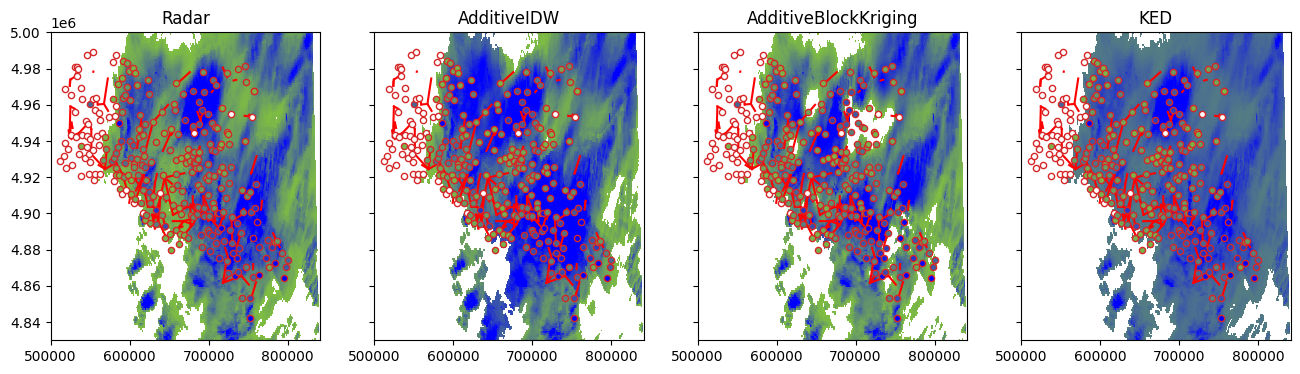

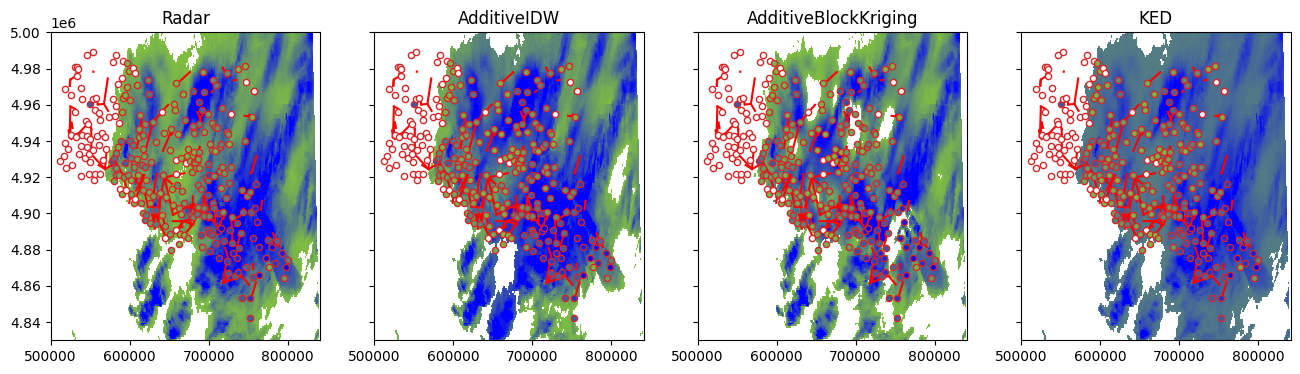

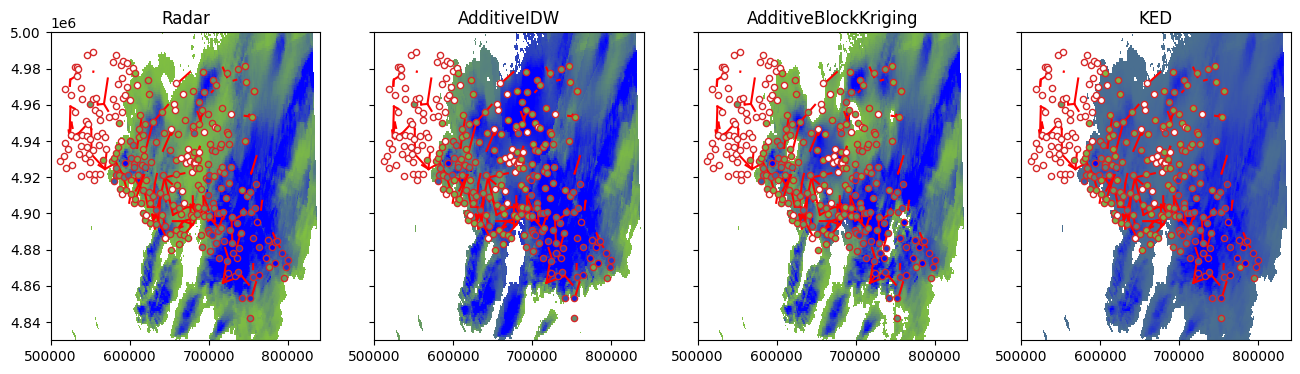

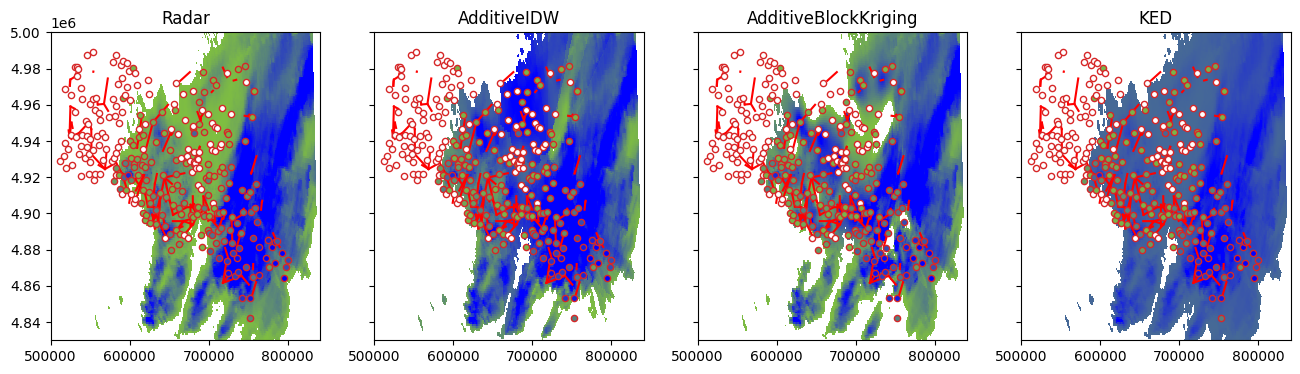

In [14]:
vmax = 3
for time in ds_cmls.time:
    fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
    ax[0].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_amount.data,
        vmin=0,
        vmax=vmax,
        cmap=cmap_rain,
    )
    
    ax[1].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveIDW.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )
    
    ax[2].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_additiveBK.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )
    
    ax[3].pcolormesh(
        ds_rad.xs,
        ds_rad.ys,
        ds_rad.sel(time=time).rainfall_KED.data,
        vmin=0,
        vmax=vmax,
        zorder=1,
        cmap=cmap_rain,
    )
    
    ax[0].set_title("Radar")
    ax[1].set_title("AdditiveIDW")
    ax[2].set_title("AdditiveBlockKriging")
    ax[3].set_title("KED")
    ax[0].set_xlim(5e5, )
    ax[1].set_xlim(5e5, )
    ax[2].set_xlim(5e5, )
    ax[3].set_xlim(5e5, ) 
    ax[0].set_ylim(4.830e6, 5e6)
    ax[1].set_ylim(4.830e6, 5e6)        
    ax[2].set_ylim(4.830e6, 5e6)
    ax[3].set_ylim(4.830e6, 5e6)
    
    for ax_i in range(len(ax)):
        for cml_id in ds_cmls.cml_id:
            ax[ax_i].plot(
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_x,
                    ds_cmls.sel(cml_id=cml_id).site_1_x,
                ],
                [
                    ds_cmls.sel(cml_id=cml_id).site_0_y,
                    ds_cmls.sel(cml_id=cml_id).site_1_y,
                ],
                "red",
                zorder=1,
            )
    
    for ax_i in range(len(ax)):
        for station_id in ds_gauges.id:
            ax[ax_i].scatter(
                station_id.x,
                station_id.y,
                c=ds_gauges.sel(id=station_id, time=time).rainfall_amount,
                cmap=cmap_rain,
                edgecolors="C3",
                vmin=0,
                vmax=vmax,
                s=20,
                zorder=2,
            )
    plt.show()

# Compare to city rain gauges

In [15]:
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad,
    da_point_data=ds_gauges,
    nnear=1,
    stat="best",
)

radar_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

IDW_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

BK_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBK,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

KED_at_points = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges.rainfall_amount,  # Why do we require rainfal amount?
)

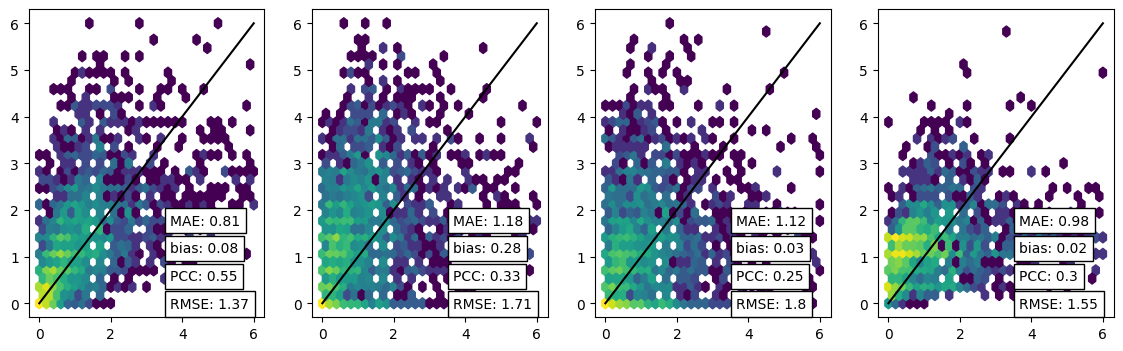

In [16]:
extent = [0, 6, 0, 6]
gridsize = 30

pred_models = [radar_at_points, IDW_at_points, BK_at_points, KED_at_points]
fig, ax = plt.subplots(1, len(pred_models), figsize=(14, 4))
ground = ds_gauges.rainfall_amount.data.ravel()
for i in range(len(pred_models)):
    tar = pred_models[i].data.ravel()
    keep = np.ones(ground.shape).astype(bool)
    # ground contains NaNs
    keep = (radar_at_points.data.ravel() > 0)&(~np.isnan(ground))
    ax[i].hexbin(
        ground[keep], tar[keep], mincnt=1, extent=extent, gridsize=gridsize, bins="log"
    )
    ax[i].text(
        0.6,
        0.03,
        "RMSE: " + str(round(np.sqrt(np.mean((ground[keep] - tar[keep]) ** 2)), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.12,
        "PCC: " + str(round(np.corrcoef(ground[keep], tar[keep])[0, 1], 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.21,
        "bias: "
        + str(round(np.mean(tar[keep] - ground[keep]) / np.mean(ground[keep]), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].text(
        0.6,
        0.3,
        "MAE: " + str(round(np.mean(np.abs(tar[keep] - ground[keep])), 2)),
        bbox={"facecolor": "white", "edgecolor": "black"},
        transform=ax[i].transAxes,
    )
    ax[i].plot([0, extent[1]], [0, extent[1]], "k")